In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.utils as np_utils
import random
from IPython.display import HTML, display

In [55]:
num_patterns = 200
num_features = 2
num_classes = 2
mu, sigma = 0, 0.5

XNegative = np.random.normal(mu, sigma, (num_patterns, num_features)) + np.array([0.5, 0.5])
YNegative = np.zeros(num_patterns, dtype=int)
XPositive = np.random.normal(mu, sigma,(num_patterns, num_features)) + np.array([-0.5, -0.5])
YPositive = np.ones(num_patterns, dtype=int) * 1
X = np.concatenate((XNegative, XPositive), axis=0)
num_patterns = num_patterns * num_classes
Y = np.concatenate((YNegative, YPositive), axis=0)

Y_hot = np.zeros((Y.size, Y.max()+1))
Y_hot[np.arange(Y.size),Y] = 1
Y = np.reshape(Y, (-1,1))


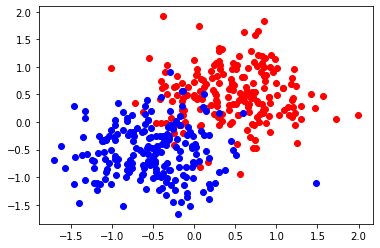

In [56]:
plt.scatter(X[0:int(num_patterns/2),0], X[0:int(num_patterns/2),1], color='red')
plt.scatter(X[int(num_patterns/2): int(2*num_patterns/2),0], X[int(num_patterns/2): int(2*num_patterns/2),1], color='blue')

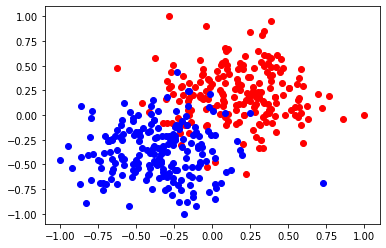

In [57]:
X = 2*((X - X.min(0)) / X.ptp(0)) -1
plt.scatter(X[0:int(num_patterns/2),0], X[0:int(num_patterns/2),1], color='red')
plt.scatter(X[int(num_patterns/2): int(2*num_patterns/2),0], X[int(num_patterns/2): int(2*num_patterns/2),1], color='blue')

In [58]:
percent = 0.8
n = int(percent * num_patterns) 
indexes = [i for i in range(num_patterns)]
random.shuffle(indexes)

index_train = indexes[0:n]
index_test = indexes[n::]

y_train = Y[index_train, :]
y_test = Y[index_test, :]
X_train = X[index_train, :]
X_test = X[index_test, :]

batch_size = 10
epochs = 50

def build_logistic_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=num_features, activation='softmax'))

    return model

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

model = build_logistic_model(num_features, num_classes)

model.summary()

# compile the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_data=(X_test, Y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 1s 19ms/step - loss: 0.5942 - accuracy: 0.8313 - val_loss: 0.5931 - val_accuracy: 0.8250
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.5779 - accuracy: 0.8594 - val_loss: 0.5765 - val_accuracy: 0.8500
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.5628 - accuracy: 0.8719 - val_loss: 0.5609 - val_accuracy: 0.8625
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.5486 - accuracy: 0.8875 - val_loss: 0.5464 - val_accuracy: 0.8750
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.5352 - accuracy: 0.

In [59]:
model.predict(X_test)
pred = model.predict(np.array(X_test))
predictions = np.argmax(pred, axis=-1)

inference = np.concatenate((np.reshape(pred, (-1,num_classes)), np.reshape(predictions, (-1,1)), y_test), axis=1)
inference_sorted = np.array(sorted(inference, key=lambda a_entry: 1.0/a_entry[1]))
num_test_patterns = inference_sorted.shape[0]
display(HTML(
   '<table ><tr><td>Negative Class Output</td><td>Positive Class Output</td><td>Predicted</td><td>Target</td></tr><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in inference_sorted)
       )
))


Negative Class Output,Positive Class Output,Predicted,Target
0.033881641924381256,0.9661183953285217,1.0,1.0
0.03427858650684357,0.9657214283943176,1.0,1.0
0.04534031078219414,0.9546597003936768,1.0,1.0
0.05254976823925972,0.9474502801895142,1.0,1.0
0.0579407624900341,0.9420592188835144,1.0,1.0
0.07346045225858688,0.9265395402908325,1.0,1.0
0.0758499950170517,0.9241500496864319,1.0,1.0
0.07923067361116409,0.9207693338394165,1.0,1.0
0.08304934948682785,0.9169507026672363,1.0,1.0
0.08462408185005188,0.9153758883476257,1.0,1.0


# Receiver Operating Characteristic   
[From Wikipedia, the free encyclopedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)


In [60]:
P_target = np.sum(y_test)
N_target = num_test_patterns - P_target

# At the beggining of ROC contruction all patterns are predicted as false because the thresold is maximun

TP = 0              #labeled 1  predicted 1
FN = P_target       #labeled 1  predicted 0
FP = 0              #labeled 0  predicted 1 
TN = N_target       #labeled 1 predicted 0

x = []
y = []

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
x.append(FPR)
y.append(TPR)

target = inference_sorted[:, 3]
predicted = inference_sorted[:, 2]
for i in range(num_test_patterns):

    if(target[i] == 1):
        TP += 1
        FN -= 1
    else:
        TN -= 1
        FP += 1
    
    TPR = TP/(TP + FN)
    FPR = FP/(FP + TN)
    x.append(FPR)
    y.append(TPR)



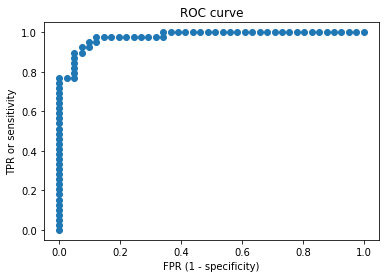

In [61]:
fig, ax = plt.subplots()
plt.title('ROC curve')
ax.set_ylabel('TPR or sensitivity') 
ax.set_xlabel('FPR (1 - specificity)') 
plt.scatter(x, y)

In [62]:
AUC = 0
for i in range(2, num_test_patterns):
    AUC += (x[i] - x[i-1])*(y[i] + y[i-1])/2

print(AUC)

0.9530956848030019


# Other Metrics

In [63]:
TP = 0       #labeled 1  predicted 1
FN = 0       #labeled 1  predicted 0
FP = 0       #labeled 0  predicted 1 
TN = 0       #labeled 1 predicted 0

for i in range(num_test_patterns):

    if(target[i] == 1):
        if(predicted[i] == 1):
            TP += 1
        else:
            FN += 1
    else:
        if(predicted[i] == 1):
            FP += 1
        else:
            TN += 1

## Sensitivity, recall, hit rate, or true positive rate (TPR)
${\displaystyle \mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}=1-\mathrm {FNR} }$

In [64]:
TPR = TP / (TP + FN)
print(TPR)

0.9487179487179487


## Specificity, selectivity or true negative rate (TNR)
${\displaystyle \mathrm {TNR} ={\frac {\mathrm {TN} }{\mathrm {N} }}={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FP} }}=1-\mathrm {FPR} }$

In [65]:
TNR = TN / (TN + FP)
print(TNR)

0.9024390243902439


## Precision or positive predictive value (PPV)  
${\displaystyle \mathrm {PPV} ={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FP} }}=1-\mathrm {FDR} }$

In [66]:
PPV = TP / (TP + FP)
print(PPV)

0.9024390243902439


## Miss rate or false negative rate (FNR)  
${\displaystyle \mathrm {FNR} ={\frac {\mathrm {FN} }{\mathrm {P} }}={\frac {\mathrm {FN} }{\mathrm {FN} +\mathrm {TP} }}=1-\mathrm {TPR} }$

In [67]:
FNR = FN / (FN + TP)
print(FNR)

0.05128205128205128


## Fall-out or false positive rate (FPR)
${\displaystyle \mathrm {FPR} ={\frac {\mathrm {FP} }{\mathrm {N} }}={\frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TN} }}=1-\mathrm {TNR} }$

In [68]:
FPR = FP / (FP + TN)
print(FPR)

0.0975609756097561
